# Basis Analysis

 - focus on  `orders`, `customers`, `payments`, `products` and `reviews` datasets. 
 
    * Analysis by Purchase Period
    * Analysis by Customer State
    * Analysis by Payment Type
    * Analysis by Product Categories
    * Analysis by Review Score

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)


In [2]:
# plot functions
def format_spines(ax, right_border=True):
    """
    this function sets up borders from an axis and personalize colors
    """    
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    
def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    """
    this function plots data setting up frequency and percentage in a count plot;
    this also sets up borders and personalization
    """    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')

    # Setting up borders
    format_spines(ax)
    format_spines(ax2)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()

def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    """
    this function plots data setting up frequency and percentage in a bar plot; 
    this algo sets up borders and personalization
    """
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')

    # Setting borders
    format_spines(ax)
    format_spines(ax2)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=13, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()
    
def add_series_working_days(series_name, df, date_col1, date_col2):
    """
    this function computes working days between two date columns in a dataframe
    """
    # Computing difference between dates
    time_list = []
    idx = 0
    dates = df[date_col1].values.astype('datetime64[D]')
    second_dates = df[date_col2].values.astype('datetime64[D]')
    for date in dates:
        second_date = second_dates[idx]
        try:
            workdays = np.busday_count(date, second_date)
        except:
            workdays = np.NaN
        time_list.append(workdays)
        idx += 1
    
    # Adding to a dataframe and dropping null values
    df_return = df.copy()
    df_return[series_name] = pd.Series(time_list)
    df_return.dropna(inplace=True)
    
    return df_return

def communicate_params(frete, entrega, estimativa):
    """
    this function assists the analysis by customer state and plots usefull information
    in the first row of an axis
    """
    # Communicating mean freight value
    axs[0, 0].text(0.5, 0.12, str(f'Mean Freight Value \nR${frete:.2f}'),
                   fontsize=13, ha='center')
    axs[0, 0].axis('off')
    
    # Communicating mean delivery time
    axs[0, 1].text(0.5, 0.12, 
                   str(f'Mean Delivery Time \n{int(entrega)} working days.'),
                   fontsize=13, ha='center')
    axs[0, 1].axis('off')
    
    # Communicating difference between delivery time and estimated time
    if mean_diff_estimative > 0:
        inf = 'before'
    else:
        inf = 'after'
    text_diff_estimative = f'On average, orders are delivered \n{int(estimativa)} \
working days \n{inf} estimated time.'
    axs[0, 2].text(0.5, 0.10, 
                   str(text_diff_estimative), fontsize=13, ha='center')
    axs[0, 2].axis('off')
    
def plot_param(df, col, title, xlim, n_row, n_col, y='customer_state', div_xlim=0, 
               one_axis=False):
    """
    this function is used to answear comparative questions in plots (top 5 and last 5)
    """
    # Setting up axis
    if one_axis:
        ax_top = axs[n_col]
        ax_last = axs[n_col+1]
    else:
        ax_top = axs[n_row, n_col]
        ax_last = axs[n_row+1, n_col]
    
    # First step: plotting top 5 from an attribute
    df.sort_values(by=col, ascending=False, inplace=True)
    top5 = df.iloc[:5, :]
    sns.barplot(x=col, y=y, data=top5, ci=None, palette='Blues_d', ax=ax_top)
    format_spines(ax_top, right_border=False)
    ax_top.set_title(title)
    ax_top.set_xlim(0, xlim)
    
    # Second step: plotting last 5 from an attribute
    last5 = df.iloc[-5:, :]
    sns.barplot(x=col, y=y, data=last5, ci=None, palette='Blues_d', ax=ax_last)
    format_spines(ax_last, right_border=False)
    ax_last.set_title(title.replace('Higher', 'Lower'))
    if div_xlim > 0:
        ax_last.set_xlim(0, xlim/div_xlim)
    else:
        ax_last.set_xlim(0, xlim)

## Explorting Data

In [3]:
# Reading all datasets
df_customers = pd.read_csv('data/olist_customers_dataset.csv')
df_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
df_orders = pd.read_csv('data/olist_orders_dataset.csv')
df_items = pd.read_csv('data/olist_order_items_dataset.csv')
df_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
df_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
df_products = pd.read_csv('data/olist_products_dataset.csv')
df_sellers = pd.read_csv('data/olist_sellers_dataset.csv')

In [4]:
dataframes = {
    'Customers': df_customers,
    'Geolocation': df_geolocation,
    'Orders': df_orders,
    'Items': df_items,
    'Payments': df_payments,
    'Reviews': df_reviews,
    'Products': df_products,
    'Sellers': df_sellers
}

for df_name, df in dataframes.items():
    print(f'{df_name}')
    print(f'{list(df.columns)}\n')

Customers
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Geolocation
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

Orders
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Items
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Reviews
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

Products
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_wid

### Null Data

In [5]:
# Counting null data in datasets with True results in task above
for df_name, df in dataframes.items():
    if df.isnull().any().any():
        print(f'Dataset: {df_name}\n')
        print(f'{df.isnull().sum()}\n')

Dataset: Orders

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Dataset: Reviews

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Dataset: Products

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64



Null data in Orders dataset are from:

- Orders without approval date;
    - Orders that weren't delivered to the carrier;
    - Orders that weren't delivered to the customer.

- Null data in Reviews dataset are from:
    * Orders without comments;
    * Comments without title;

- Null data in Products dataset are from:
    * Products without categories, with no name information, description, photos and attributes.

In [6]:
# Data type
for df_name, df in dataframes.items():
    print(f'Dataset: {df_name}\n')
    print(f'{df.dtypes}\n')

Dataset: Customers

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Dataset: Geolocation

geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

Dataset: Orders

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Dataset: Items

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
frei

In [7]:
# Change columns to datetime in orders dataset
time_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in time_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Data type
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

## Analysis by Purchase Period

In [8]:
# Purchase Year
df_orders['order_purchase_year'] = \
df_orders['order_purchase_timestamp'].dt.year

# Purchase Month
df_orders['order_purchase_month'] = \
df_orders['order_purchase_timestamp'].dt.month

# Purchase Day of Week
df_orders['order_purchase_dayofweek'] = \
df_orders['order_purchase_timestamp'].dt.dayofweek


In [9]:
print(f'First observation was in: \
{df_orders["order_purchase_timestamp"].min()}')
print(f'Last observation was in: \
{df_orders["order_purchase_timestamp"].max()}')


First observation was in: 2016-09-04 21:15:19
Last observation was in: 2018-10-17 17:30:18


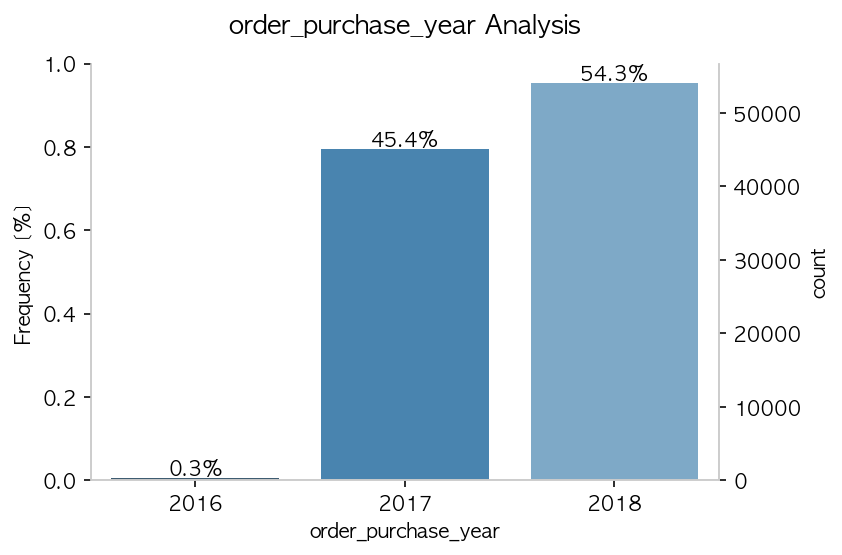

In [10]:
# Counting online sell by year
count_plot(feature='order_purchase_year', df=df_orders)
plt.show()


In [11]:
# Merging items dataset
df_orders_items = df_orders.merge(df_items, on='order_id', how='inner')

# Creating new column with item value + freight value
df_orders_items['total_sales'] = df_orders_items['price'] + df_orders_items['freight_value']

# Grouping by annual and monthly sales
df_sales = \
df_orders_items.groupby(['order_purchase_year', 'order_purchase_month'], 
                         as_index=False).sum()\
.loc[:, ['order_purchase_year', 'order_purchase_month', 'total_sales']]

df_sales_2016 = df_sales[df_sales['order_purchase_year']==2016]
df_sales_2017 = df_sales[df_sales['order_purchase_year']==2017]
df_sales_2018 = df_sales[df_sales['order_purchase_year']==2018]

In [47]:
# Filling data in months that didn't appeared on dataset
months = np.arange(1, 13)
df_append = pd.DataFrame({})
grouped_dfs = df_sales_2016, df_sales_2017, df_sales_2018
years = [2016, 2017, 2018]
idx = 0

for df in grouped_dfs:
    for month in months:
        # If the month doesn't exists in dataset...
        if month not in df['order_purchase_month'].values:
            dict_append = {
                'order_purchase_year': years[idx],
                'order_purchase_month': month,
                'total_sales': 0
            }
            df_append = df_append.append(dict_append, ignore_index=True)
    # Input dict on dataframe and sort values
    df = df.append(df_append).astype(int)
    df.sort_values(by='order_purchase_month', inplace=True)
    df_append = pd.DataFrame({})
    
    if idx == 0:
        df_sales_2016 = df
    elif idx == 1:
        df_sales_2017 = df
    else:
        df_sales_2018 = df
    idx += 1

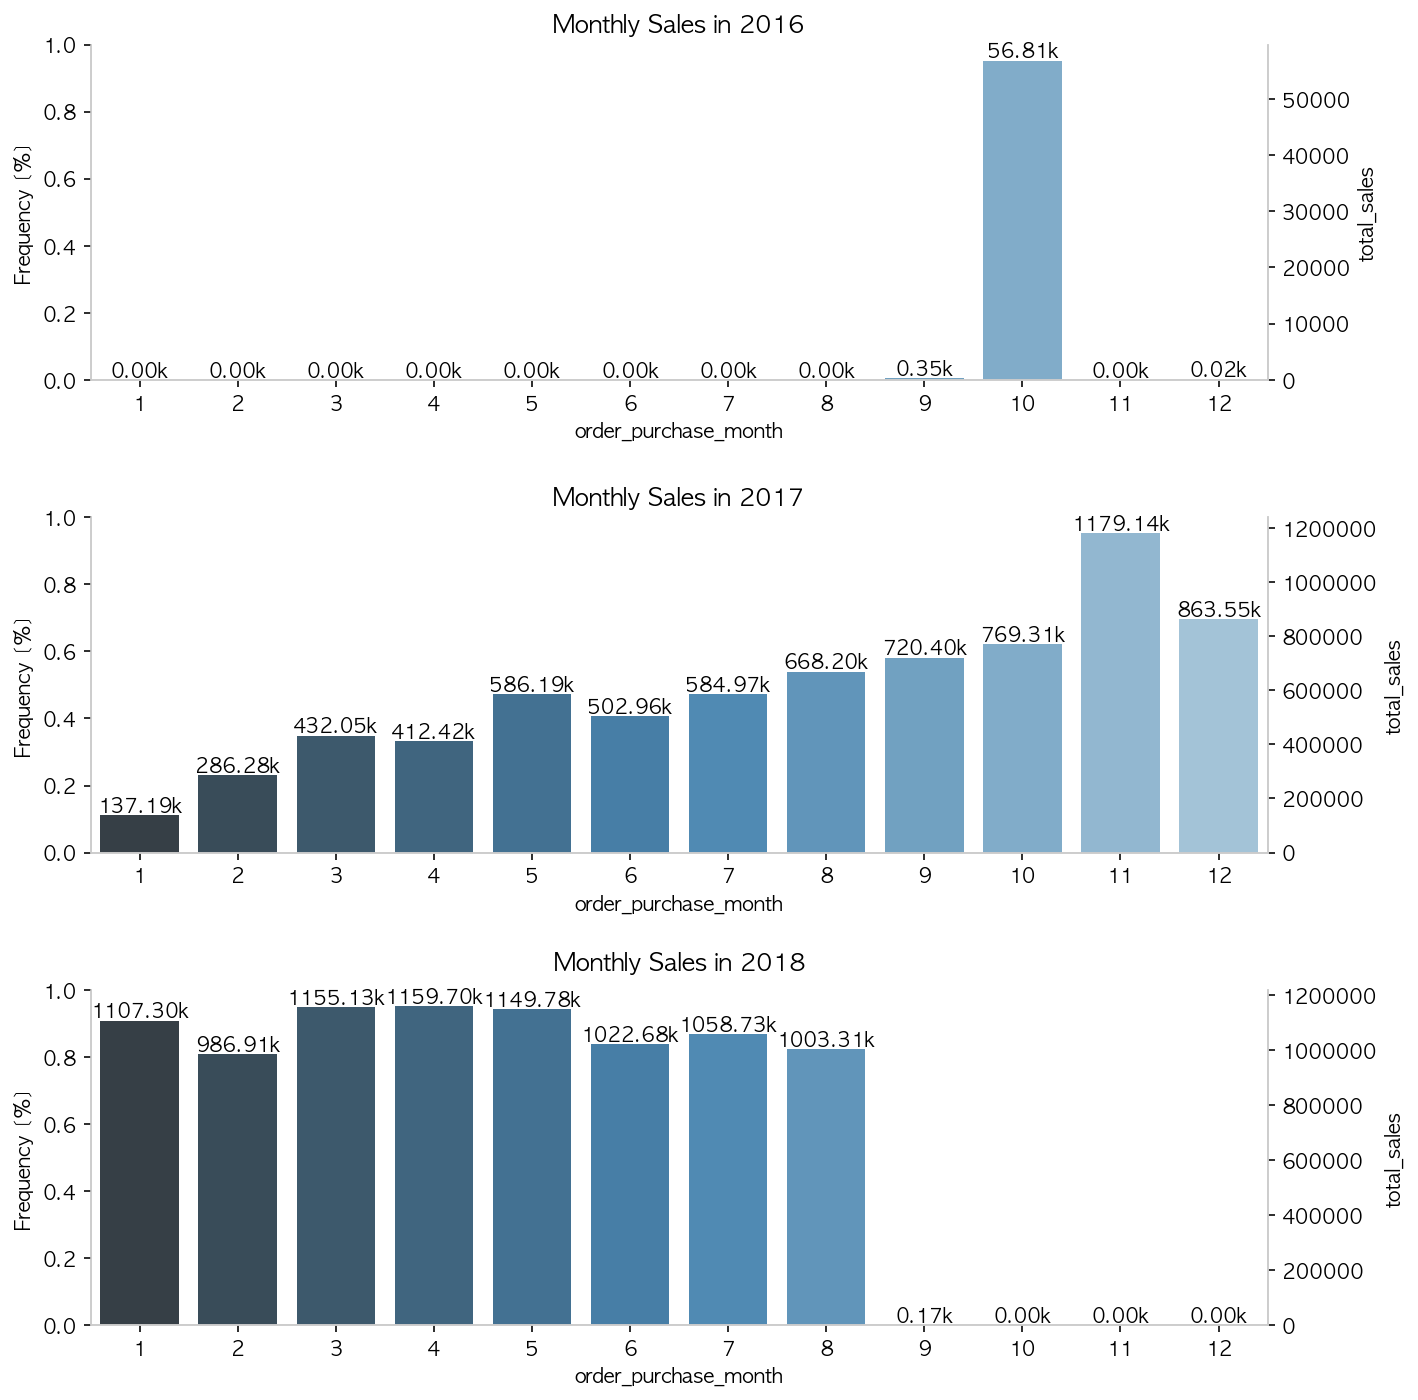

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
bar_plot(x='order_purchase_month', y='total_sales', df=df_sales_2016, ax=axs[0], value=True)
bar_plot(x='order_purchase_month', y='total_sales', df=df_sales_2017, ax=axs[1], value=True)
bar_plot(x='order_purchase_month', y='total_sales', df=df_sales_2018, ax=axs[2], value=True)
axs[0].set_title('Monthly Sales in 2016')
axs[1].set_title('Monthly Sales in 2017')
axs[2].set_title('Monthly Sales in 2018', pad=10)
plt.show()

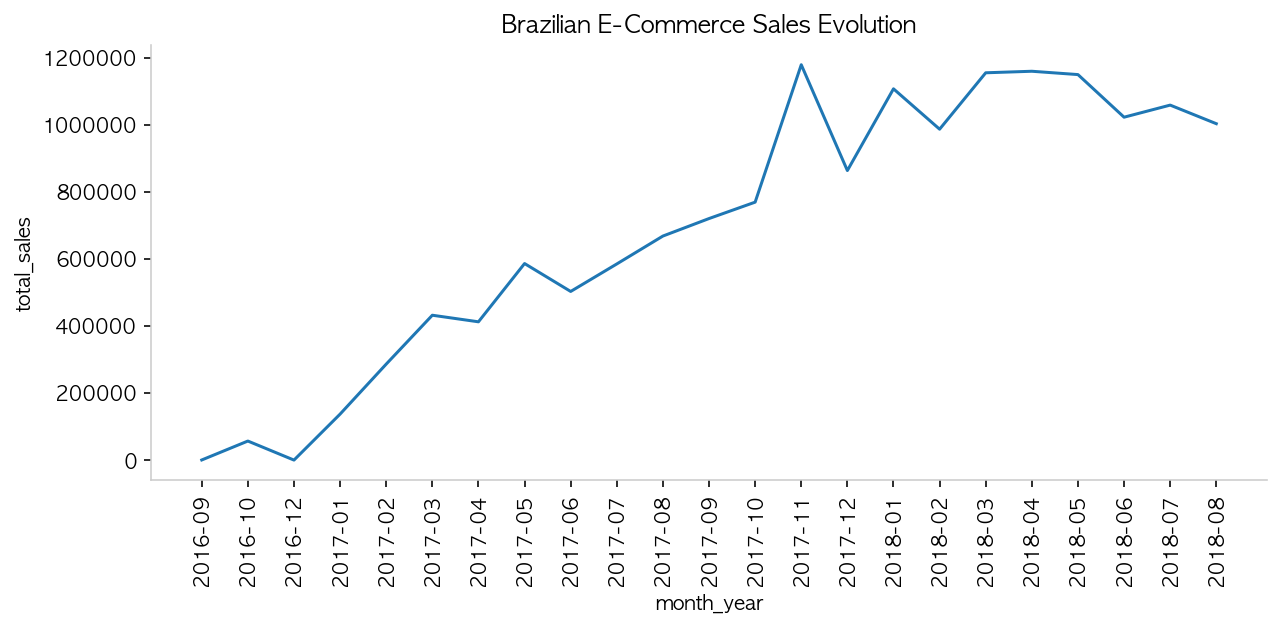

In [14]:
# Changing the month attribute for correct ordenation
df_sales['order_purchase_month'] = df_sales['order_purchase_month'].astype(str).\
apply(lambda x: '0' + x if len(x) == 1 else x)

# Creating new year-month column
df_sales['month_year'] = df_sales['order_purchase_year'].astype(str) + '-' + \
df_sales['order_purchase_month'].astype(str)
df_sales['order_purchase_month'] = df_sales['order_purchase_month'].astype(int)

# PLotting
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.lineplot(x='month_year', y='total_sales', data=df_sales.iloc[:-1, :])
format_spines(ax, right_border=False)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Brazilian E-Commerce Sales Evolution')
plt.show()


The graph show that total sales continouously increase.

Let's compare Brazilian E-Commerce in 2017 and 2018.

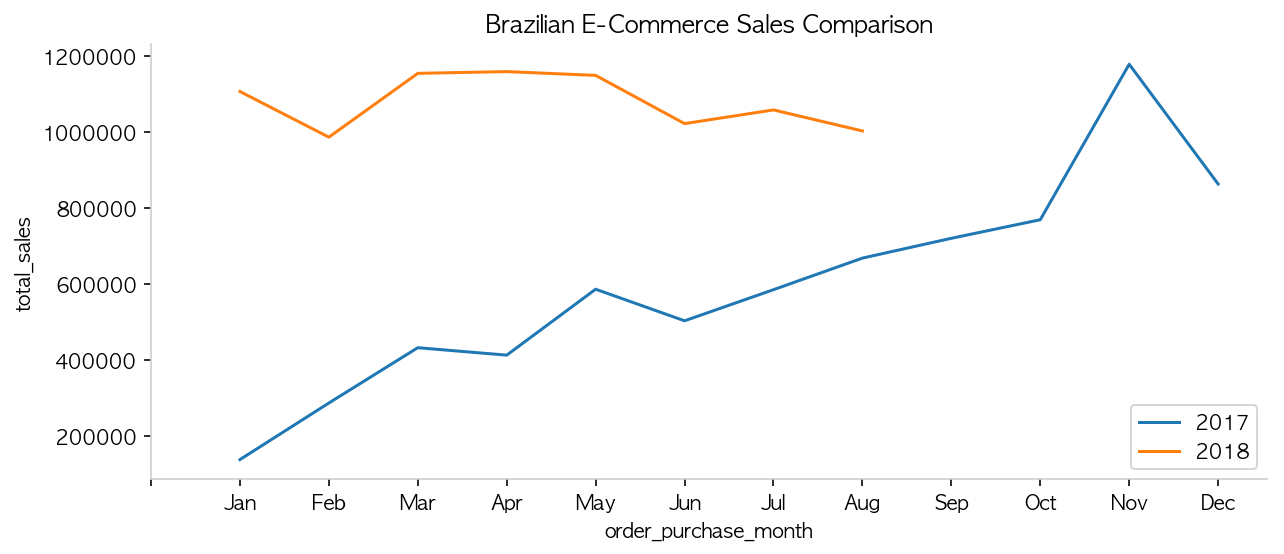

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.lineplot(x='order_purchase_month', y='total_sales', data=df_sales_2017, label='2017')
ax = sns.lineplot(x='order_purchase_month', y='total_sales', 
                  data=df_sales_2018.iloc[:-4, :], label='2018')
format_spines(ax, right_border=False)
ax.set_title('Brazilian E-Commerce Sales Comparison')
plt.xticks(np.arange(13), ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
                           'Oct', 'Nov', 'Dec'])
plt.show()


Now let's take a look at total sales by day of week in the last three years.

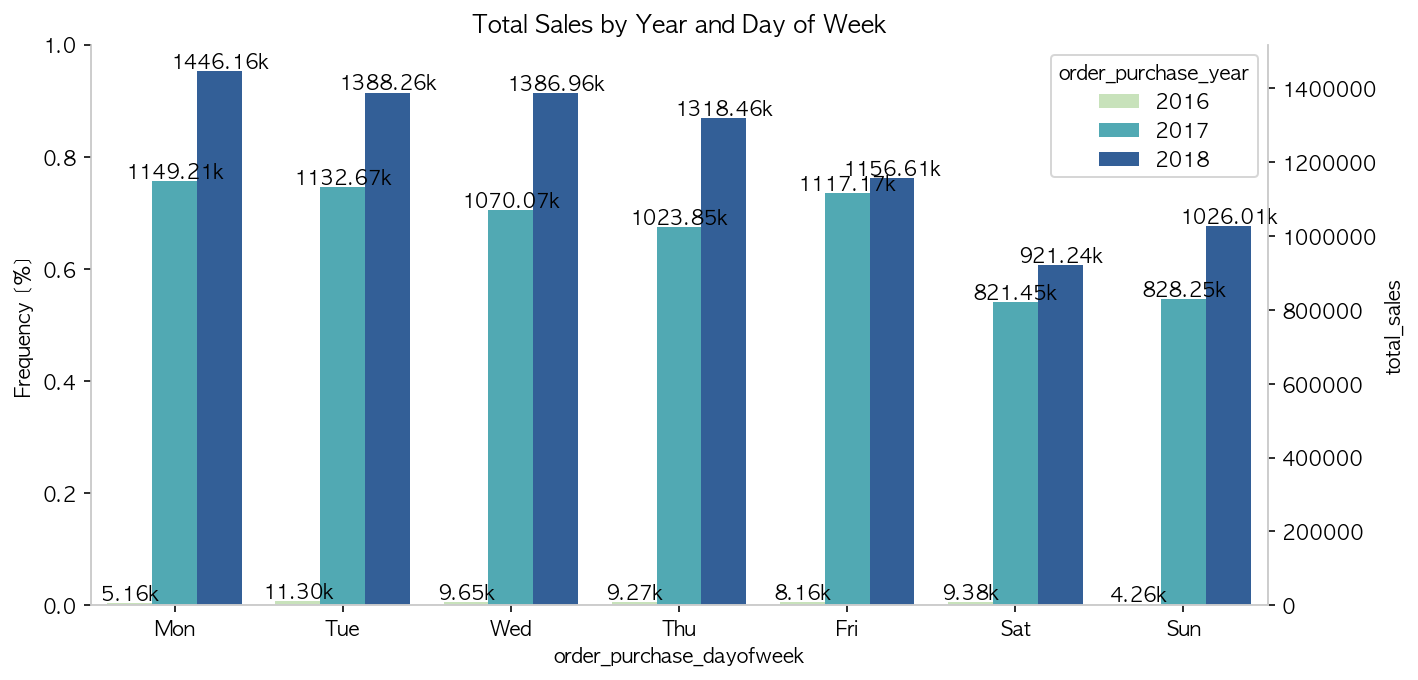

In [16]:
df_sales_dow = \
df_orders_items.groupby(['order_purchase_year', 'order_purchase_dayofweek'], 
                        as_index=False).sum()\
.iloc[:, np.c_[0, 1, 6][0]]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_plot(x='order_purchase_dayofweek', y='total_sales', hue='order_purchase_year', 
         df=df_sales_dow, colors='YlGnBu', value=True)
ax.set_title('Total Sales by Year and Day of Week')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


The graph show that total sales in 2018 are more larger than in 2017

### Analysis by Customer State

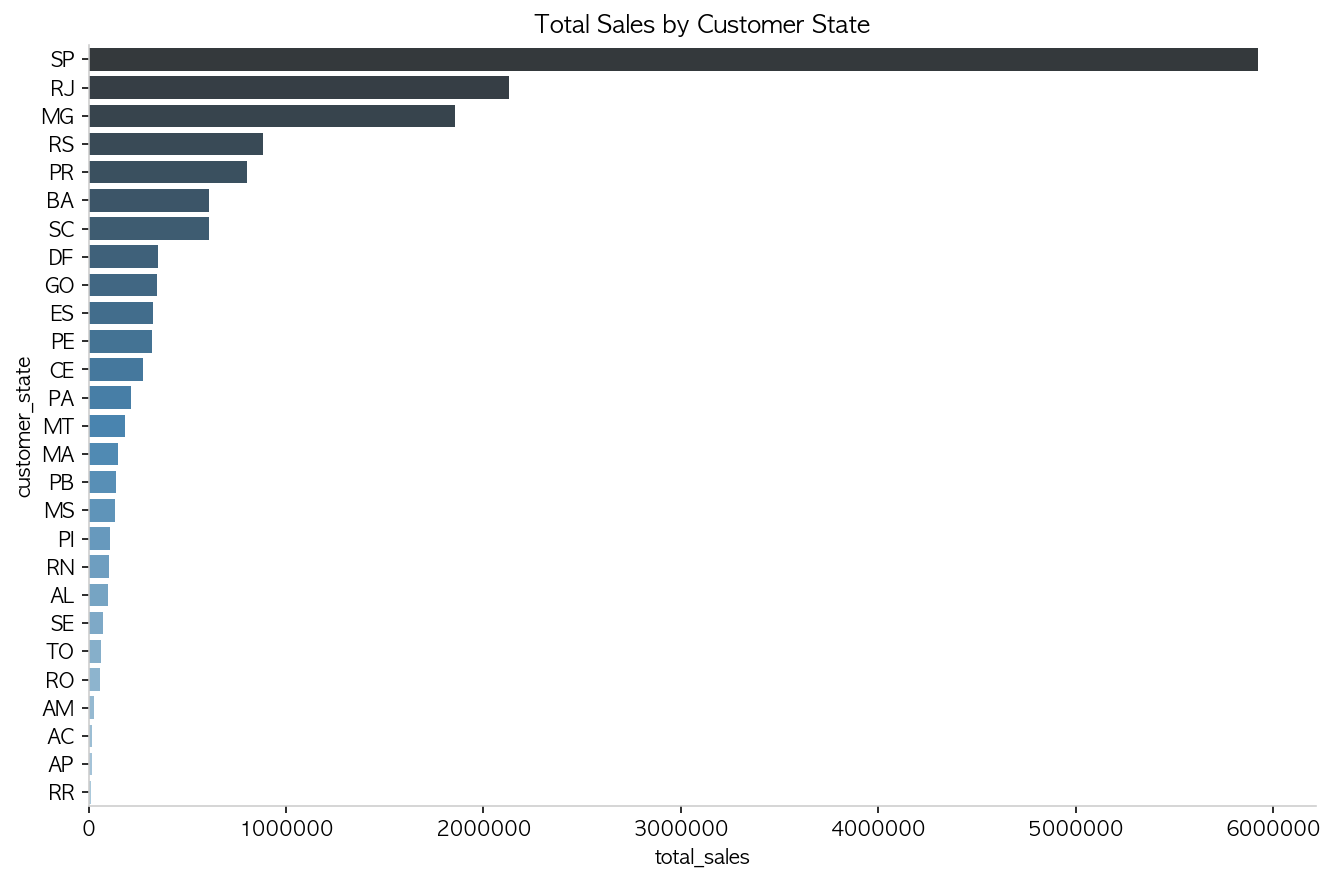

In [17]:
# Merging customer dataset
df_sales_customer = df_orders_items.merge(df_customers, on='customer_id', how='inner')

# Grouping by customer state
df_sales_state = df_sales_customer.groupby(['customer_state'], 
                                          as_index=False).sum()[['customer_state','total_sales','freight_value']]

df_sales_state.sort_values(by='total_sales', ascending=False, inplace=True)


fig, ax = plt.subplots(figsize = (11, 7))
sns.barplot(x='total_sales', y='customer_state', data= df_sales_state, palette='Blues_d')

format_spines(ax, right_border=False)
ax.set_title('Total Sales by Customer State')

plt.show()



SP(sao paulo), RJ(rio de janeiro), MG(santa barbara), RS(novo hamburgo), PR(sao jose dos pinhais), BA(cruz das almas), SC(jaragua do sul) are the cities who have the highest total sales.  

### Delivery

- Delivery time
- Days between delivery and estimated time
- Freight Value(Frieght Price)

In [18]:
# Calculate Delivery time
df_delivery_time = add_series_working_days(series_name='time_to_delivery', 
                                           df=df_sales_customer,
                                           date_col1 = 'order_purchase_timestamp', 
                                           date_col2 = 'order_delivered_customer_date')
# Grouping by customer state
df_delivery_time = df_delivery_time.groupby(['customer_state'], as_index=False).mean()
df_delivery_time = df_delivery_time.loc[:,['customer_state', 'time_to_delivery']]



In [19]:
# Computing working days between delivery and estimated time
df_diff_est_deliv = add_series_working_days(series_name='diff_est_deliv', 
                                           df=df_sales_customer,
                                           date_col1 = 'order_delivered_customer_date', 
                                           date_col2 = 'order_estimated_delivery_date')

# Grouping by customer state
df_diff_est_deliv = df_diff_est_deliv.groupby(['customer_state'], as_index=False).mean()

df_diff_est_deliv = df_diff_est_deliv.loc[:, ['customer_state', 'diff_est_deliv']]
df_diff_est_deliv['diff_est_deliv'] = df_diff_est_deliv['diff_est_deliv'].astype(int)


In [20]:
# Computing freight value and mean values
df_mean_freight = df_sales_customer.groupby(['customer_state'], 
                                as_index=False).mean().loc[:, ['customer_state','total_sales','freight_value']]



mean_freight_value = df_mean_freight['freight_value'].mean()
mean_delivery_time = df_delivery_time['time_to_delivery'].mean()
mean_diff_estimative = df_diff_est_deliv['diff_est_deliv'].mean()





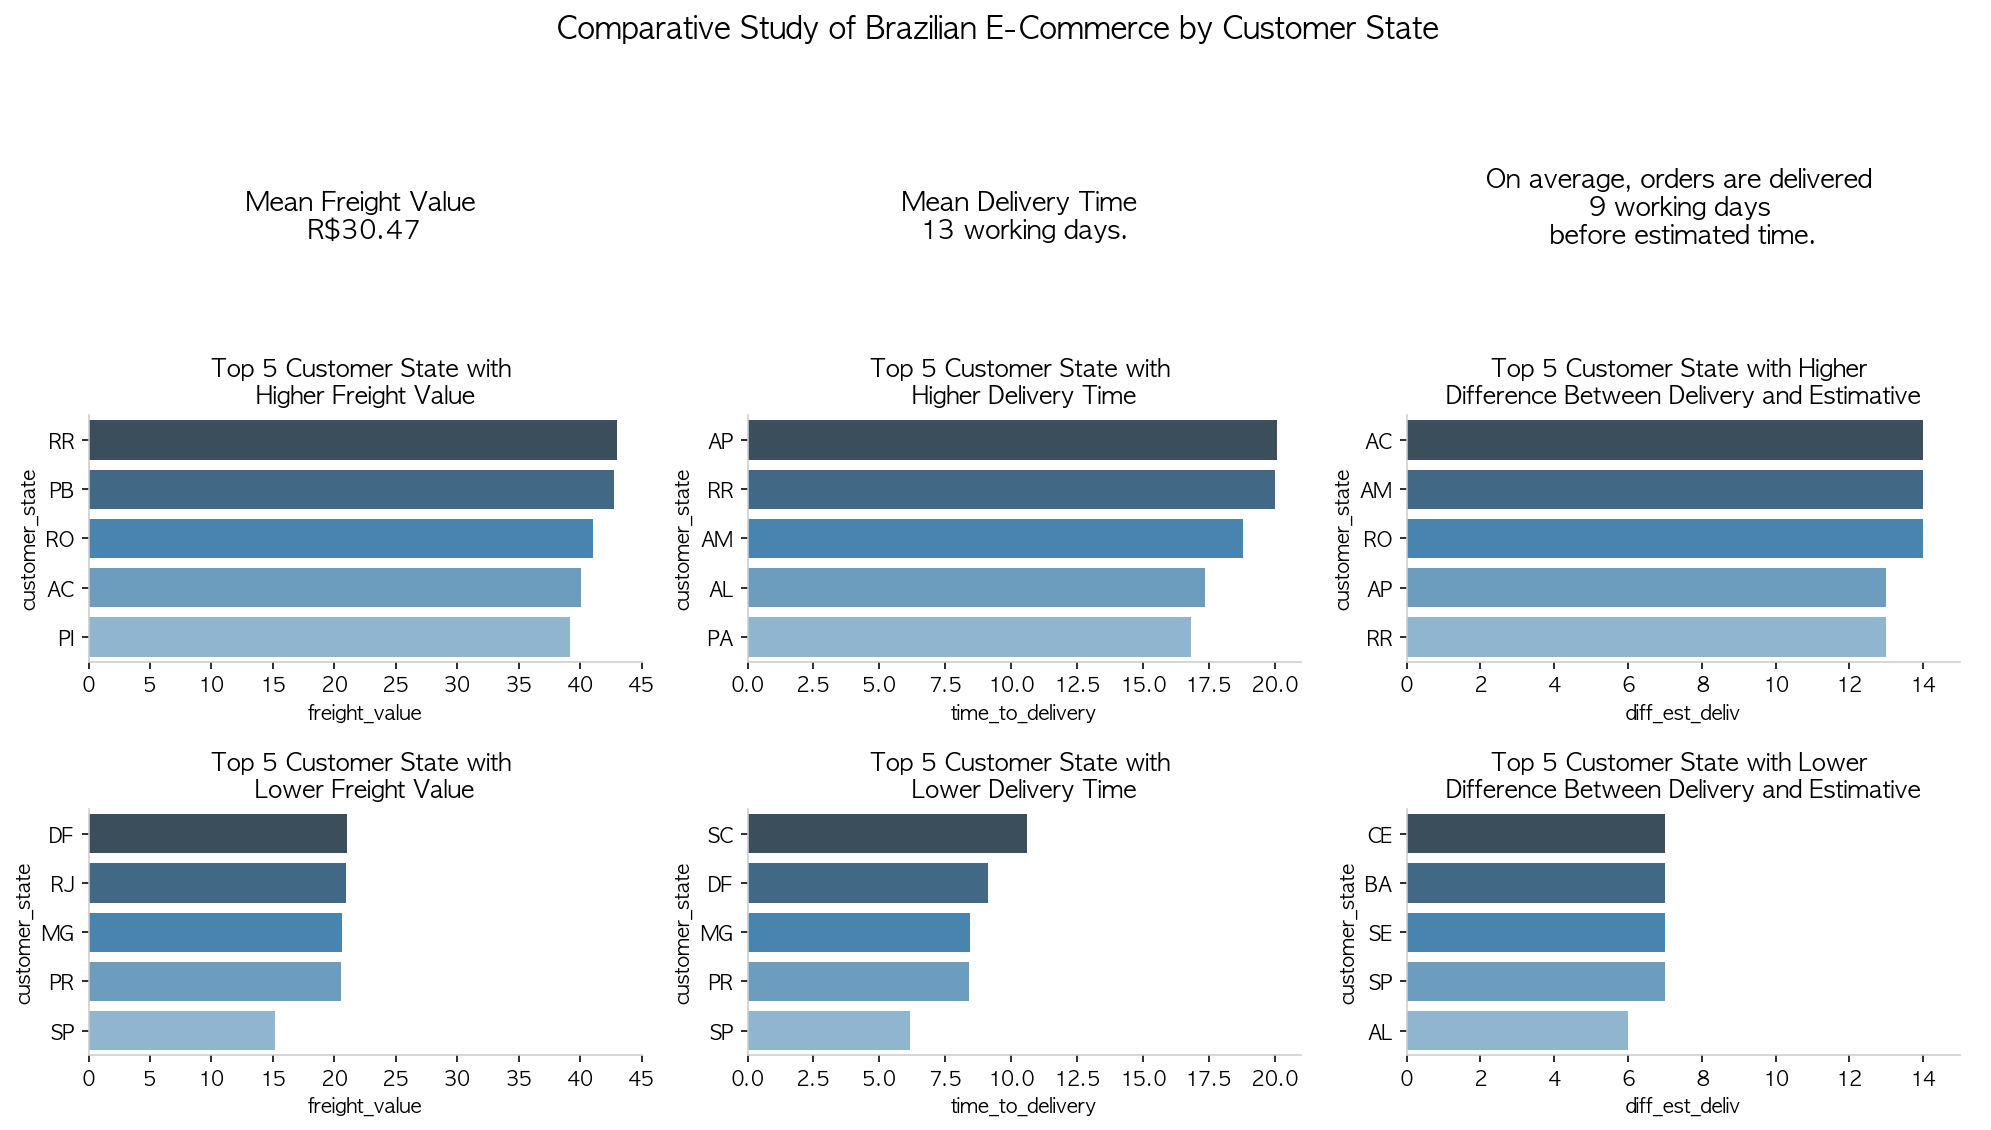

In [21]:
# Plot
fig, axs = plt.subplots(3, 3, figsize=(14, 8))
communicate_params(mean_freight_value, mean_delivery_time, mean_diff_estimative)

# Plot Freight Value
plot_param(df=df_mean_freight, col='freight_value', 
           title='Top 5 Customer State with \nHigher Freight Value', xlim=45, n_row=1, n_col=0)

# Plot Delivery Time
plot_param(df=df_delivery_time, col='time_to_delivery', 
           title='Top 5 Customer State with \nHigher Delivery Time', xlim=21, n_row=1, n_col=1)

# Plot Differece between delivery time and estimate time
plot_param(df=df_diff_est_deliv, col='diff_est_deliv', 
           title='Top 5 Customer State with Higher \nDifference Between Delivery and Estimative', 
           xlim=15, n_row=1, n_col=2)

plt.suptitle('Comparative Study of Brazilian E-Commerce by Customer State', size=15)
plt.tight_layout()
plt.show()

* Freight Value Result
    - Top 5 Highest Freight Value : PR, PB, RO, AC, PI
    - Top 5 Lowest Frieght Value: DF, RJ, MG, PR, SP
* Delivey Time Result
    - Top 5 Highest Delivery Time: AP, RR, AM, AL, PA
    - Top 5 Lowest Delivery Time: SC, DF, MG, PR, SP
* Difference Time Result
    - Top 5 Highest Difference Time between Delivery and Estimative : AC, AM, RO, AP, RR
    - Top 5 Lowest Difference Time between Delivery and Estimative : CE, BA, SE, SP, AL
    
   
Top 5 운송 비용과 Top 5 배달 시간의 지역들이 일치하지 않는 모습은 의외이다.
Top 5 예상 배달 시간과 실제 배달 시간의 차이를 조사 결과  Top5 배달시간과 상당 부분 일치하는 측면이 있다.
실제 배달 시간과 예상 배달 시간의 차이가 커질수록 고객의 불만이 늘어나므로, 원인을 규명하고 이 부분을 수정할 필요가 있다.

일반적으로 예상 배달 시간은 거리에 기반하여 측정된다.
운송측면에서 배달 시간이 지연되는 이유가 거리적인 이유외에도 다른 이유가 있는지 규명하고, 이를 좀 더 효율적인 방식으로 바꿀 필요가 있다.

일반적으로 운송 비용은 거리에 기반하여서 측정된다.
또한 Top 5 운송 비용은 배달 시간에 맞게 가격을 조정할 필요가 있으며, 운송 비용이 많이 들어가는 이유에 대해서 재조사할 필요가 있다.

## Analysis by Payment Type

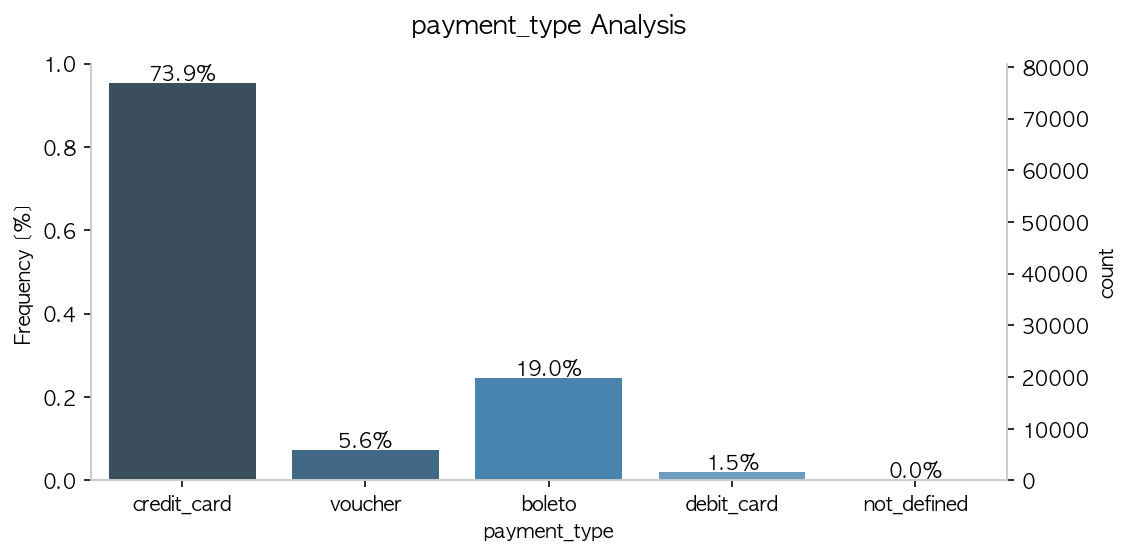

In [22]:
# Merging dataset with payment information
df_sales_payments = df_orders.merge(df_payments, on='order_id', how='inner')

fig, ax = plt.subplots(figsize=(8, 4))
count_plot(feature='payment_type', df=df_sales_payments)

Most customer use credit card as payment in ecommerce.

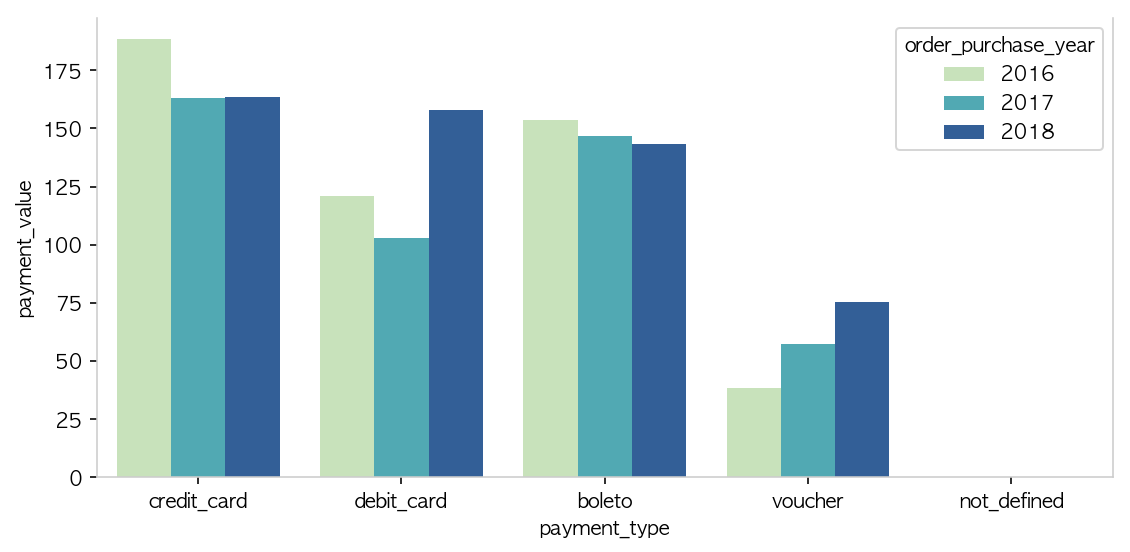

In [23]:
# Grouping data
df_payment_type_year = df_sales_payments.groupby(['order_purchase_year', 
                                                  'payment_type'], as_index=False).mean()
df_payment_type_year = df_payment_type_year.loc[:, ['order_purchase_year','payment_type','payment_value']]

df_payment_type_year = df_payment_type_year.sort_values(by='payment_value', ascending=False)



fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='payment_type', y='payment_value', data=df_payment_type_year, palette='YlGnBu', hue='order_purchase_year', ax=ax, ci=None)
format_spines(ax)
plt.tight_layout()




As long as the time goes by, people tend to use voucher with higher values for payment. The mean amount paid with debit card also increased in 2018.
            
            

## Analysis by Product Categories

In [30]:
# Merging data
df_order_products = df_orders_items.merge(df_products, on='product_id', how='inner')

# Sales counting
df_qtd_product = df_order_products.groupby(['product_category_name'], 
                                             as_index=False).count()

df_qtd_product = df_qtd_product.loc[:, ['product_category_name', 'total_sales']]


# Total sales
df_sales_product = df_order_products.groupby(['product_category_name'], 
                                             as_index=False).sum()
df_sales_product = df_sales_product.loc[:, ['product_category_name', 'total_sales']]


# Mean amount per product category
df_mean_product = df_order_products.groupby(['product_category_name'], 
                                             as_index=False).mean()
df_mean_product = df_mean_product.loc[:, ['product_category_name', 'total_sales']]




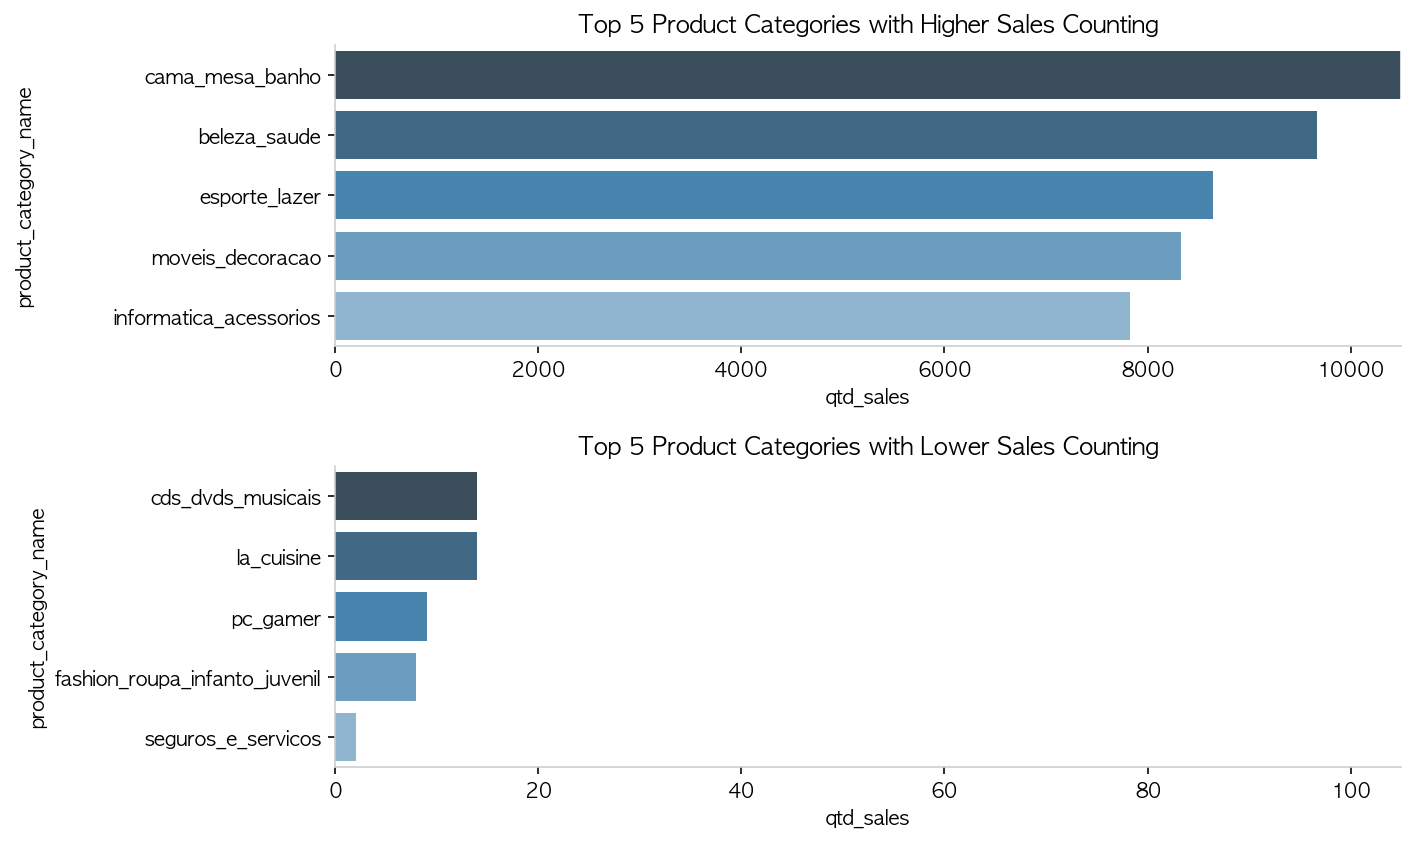

In [31]:
# Sales counting
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
plot_param(df=df_qtd_product, col='total_sales', 
           title='Top 5 Product Categories with Higher Sales Counting',
           xlim=10500, n_row=0, n_col=0, y='product_category_name', div_xlim=100,
           one_axis=True)
axs[1].set_xlabel('qtd_sales')
axs[0].set_xlabel('qtd_sales')
axs[0].set_ylabel('product_category_name', labelpad=40)
plt.tight_layout()
plt.show()

cama_mesa_banho, beleza_saude, esporte_lazer, movies_decoracao, informatica_accesorios have big demands.

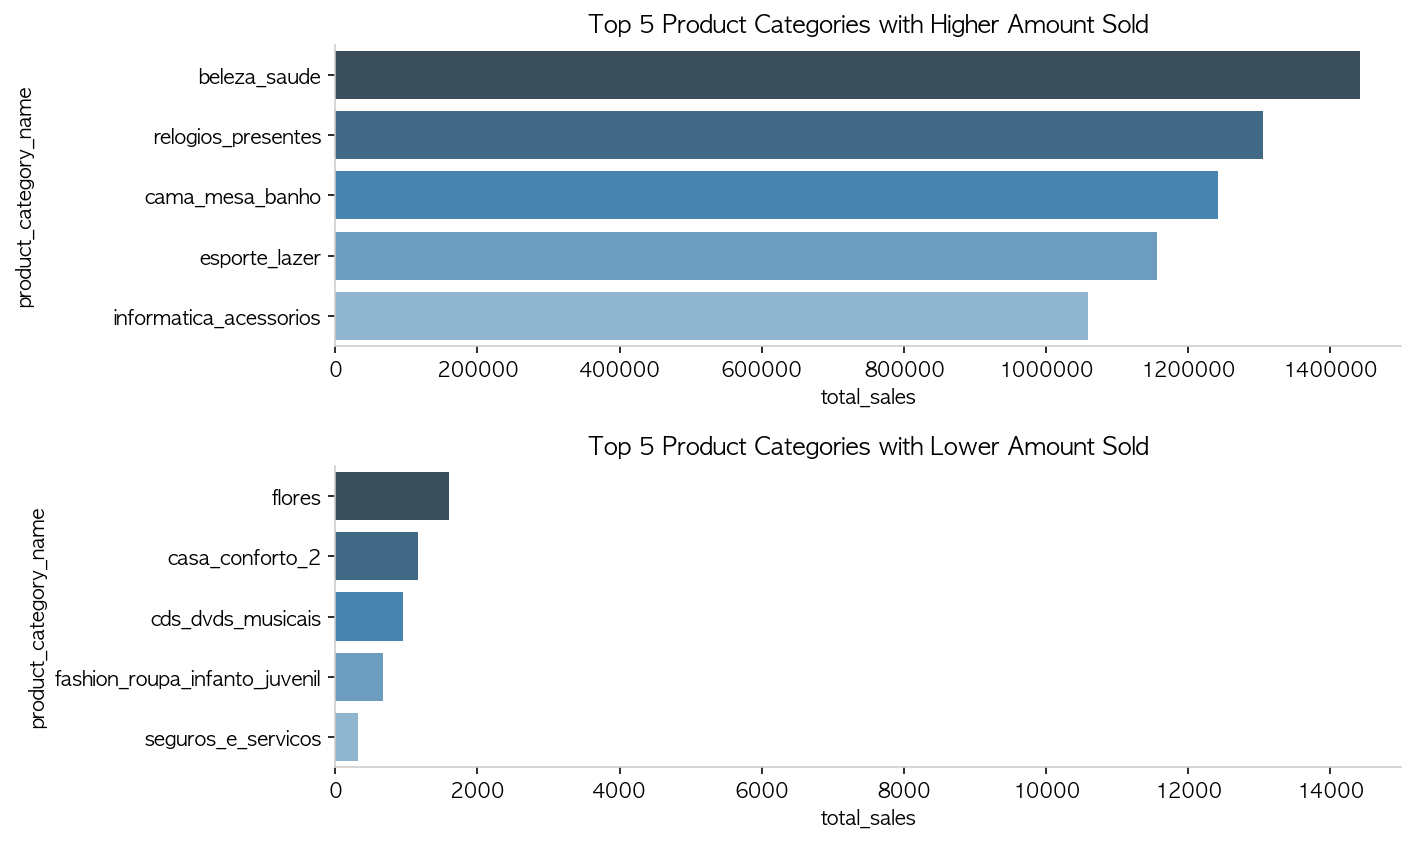

In [32]:
# Total amount of sales by product
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
plot_param(df=df_sales_product, col='total_sales', 
           title='Top 5 Product Categories with Higher Amount Sold',
           xlim=1500000, n_row=0, n_col=0, y='product_category_name', div_xlim=100,
           one_axis=True)
axs[0].set_ylabel('product_category_name', labelpad=40)
plt.tight_layout()
plt.show()

Top 5 Product Categories with Higher Amount Sold:
    - beleza_saude, relogios_presents, cama_mesa_banho, esporte_lazer, informatica_accesorios 

## Analysis by Review Score

In [33]:
# Merging datasets
df_ord_prod_cust = df_order_products.merge(df_customers, on='customer_id', how='inner')
df_info_reviews = df_ord_prod_cust.merge(df_reviews, on='order_id', how='inner')
idx_columns = ['order_id', 'order_purchase_year', 'total_sales',
               'product_category_name', 'customer_city', 'customer_state',
               'review_score']
df_info_reviews = df_info_reviews.loc[:, idx_columns]

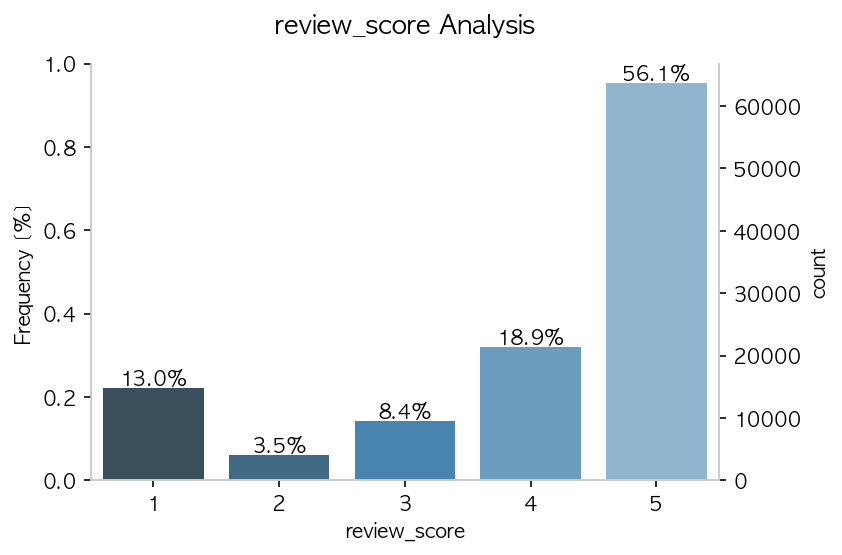

In [35]:
# Score counting
count_plot(feature='review_score', df=df_info_reviews)
plt.show()

Most customers were satisfied with shopping experience.

But, 13% of customers gave 1 point. Company need to check why the customers gave 1 point.

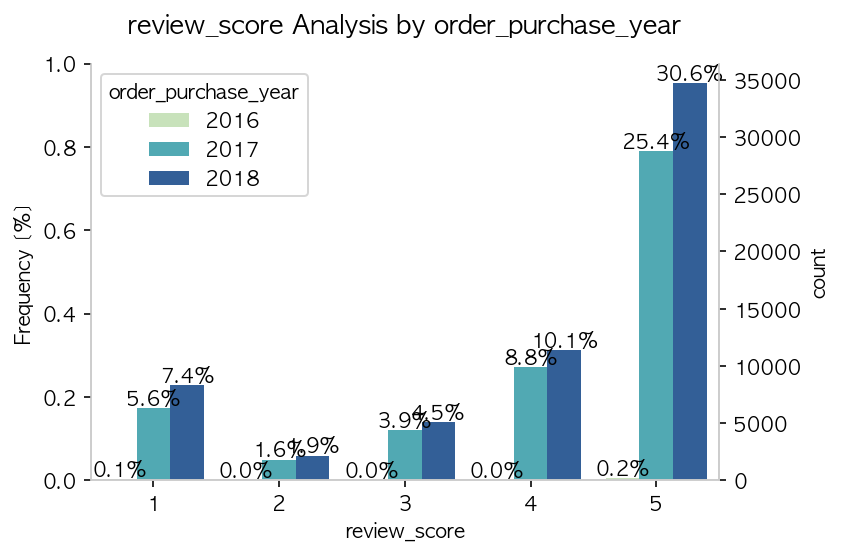

In [37]:
count_plot(feature='review_score', df=df_info_reviews,  hue='order_purchase_year', colors='YlGnBu')



Trends of review scores are similar to that of 2017 and 2018.

In [38]:
# Mean review score
mean_review_score = df_info_reviews['review_score'].mean()
print(f'Mean customer review score: {mean_review_score:.2f}')

Mean customer review score: 4.02


Mean Review Score: 4.02

In [45]:
# Grouping by customer state
df_state_review = df_info_reviews.groupby(['customer_state'], as_index=False).mean()
df_state_review.sort_values('review_score', ascending=False, inplace=True)

df_state_review = df_state_review.loc[:, ['customer_state', 'review_score']]


# Grouping by product category
df_product_review = df_info_reviews.groupby(['product_category_name'], as_index=False).mean()
df_product_review.sort_values('review_score', ascending=False, inplace=True)

df_product_review = df_product_review.loc[:,['product_category_name','review_score']]


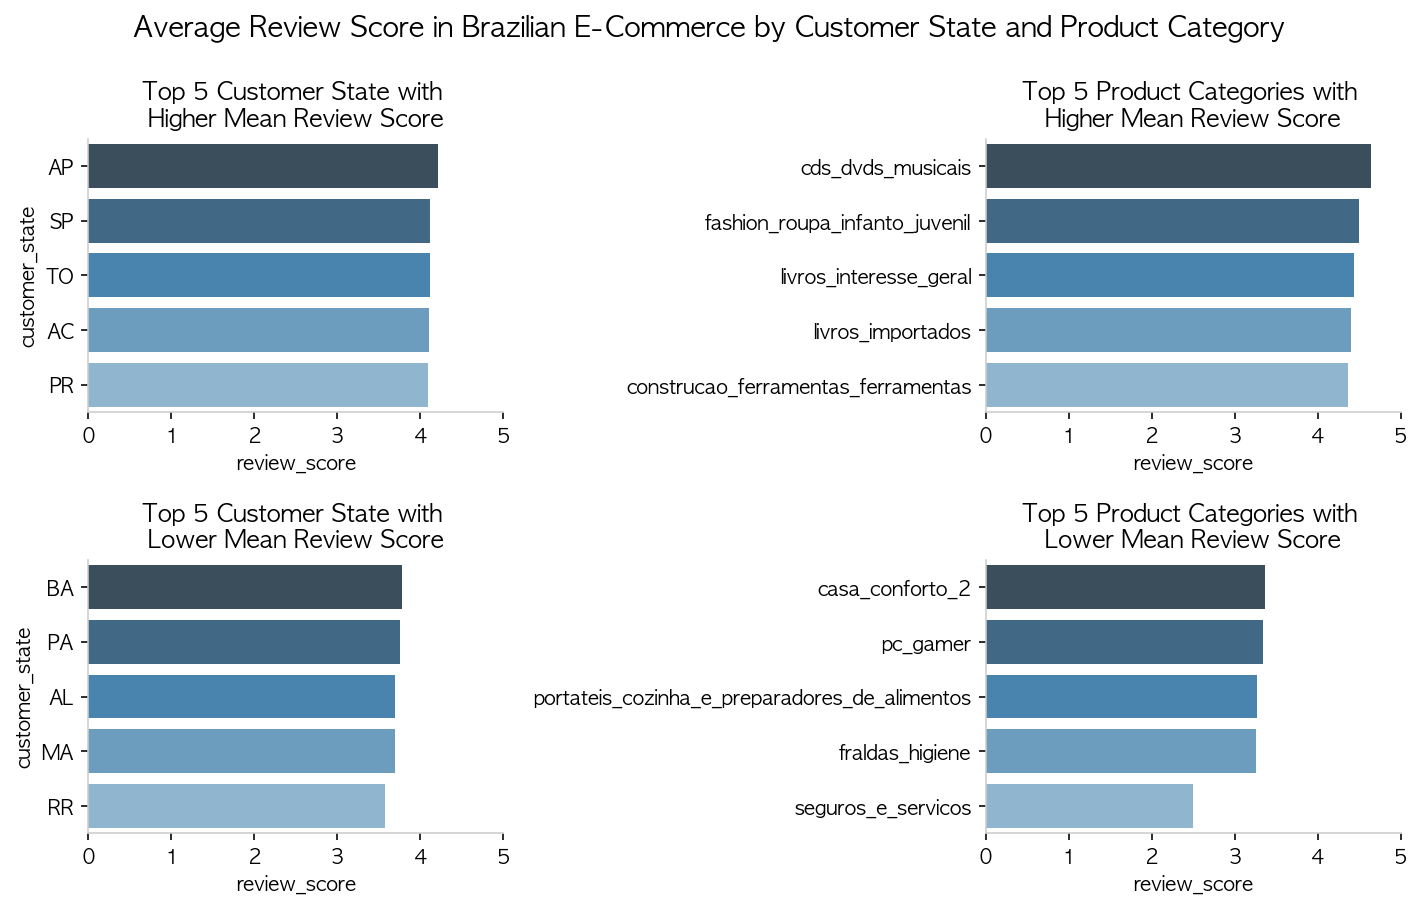

In [46]:
# Plotting data
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plot_param(df=df_state_review, col='review_score', y='customer_state',
           title='Top 5 Customer State with \nHigher Mean Review Score', xlim=5, n_row=0, n_col=0)
plot_param(df=df_product_review, col='review_score', y='product_category_name',
           title='Top 5 Product Categories with \nHigher Mean Review Score', xlim=5, 
           n_row=0, n_col=1)
axs[0, 1].set_ylabel('')
axs[1, 1].set_ylabel('')

plt.suptitle('Average Review Score in Brazilian E-Commerce by Customer State and Product Category', 
             y=1.05, size=14)
plt.tight_layout()
plt.show()

TOP 5 Customer State with Lower Mean Review Score:
BA, PA, AL, MA, RR

We can think about reasons like this:
    - PA -> Long delivery time
    - AL -> Long delivery time
    - RR -> Long delivery time, difference between delivery and estimative is long
    
We can track the reasons deeply why customer gave lower review score by review comments analysis.